# Before running this notebook, make sure you have a working environment set up with Python 3.10.15.

# Additionally, make sure you are in a directory where you can install datasets/models, they will be installed to the current directory

# Step 1: Run necessary installs

In [ ]:
%pip install torch transformers
%pip install transformers==4.37.2
%pip install datasets
%pip install pillow
%pip install matplotlib

!git clone https://github.com/haotian-liu/LLaVA.git
%cd ./LLaVA
%pip install --upgrade pip
%pip install -e .
%pip install -e ".[train]"
%pip install flash-attn --no-build-isolation
%cd ..

# You may need to restart your kernel after running this cell in order to proceed.

# Step 2: Download the dataset


In [ ]:
# Step 2: Download the dataset

from huggingface_hub import snapshot_download
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
import json
import os
import io
import sys
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

# Define the repository ID and download path
repo_id = "anonymous-yyh-1971/hf_dataset"
download_path = "./hf_dataset"  # Path where you want the dataset

# Download the dataset snapshot
snapshot_download(repo_id=repo_id, local_dir=download_path, repo_type="dataset")

print(f"Dataset downloaded to {download_path}")

json_dataset_path = './hf_dataset/test.json' # confirm that there are 5 samples and dataset was loaded correctly
with open(json_dataset_path, 'r') as f:
    data = json.load(f)

print(f"Total samples: {len(data)}")

# Step 3: Download the models (baseline and ours)


In [ ]:
# Step 3: Download the models (baseline and ours)

# BASELINE MODEL

# Define the target path for downloading the model
local_dir = os.path.join(os.getcwd(), "hf_checkpoints", "baseline", "llava-v1.5-7b-task-lora", "checkpoint-400")
model_path = "anonymous-yyh-1971/llava-v1.5-7b-baseline-400"
baseline_dir = local_dir
# Check if the directory already exists
if os.path.exists(local_dir):
    print(f"Directory already exists at {local_dir}. No download will be performed.")
else:
    # If the directory doesn't exist, proceed with the download
    os.makedirs(local_dir, exist_ok=True)  # Create directories as needed
    snapshot_download(repo_id=model_path, local_dir=local_dir)
    print(f"Model downloaded to {local_dir}.")

# OUR MODEL

# Define the target path for downloading the model
local_dir = os.path.join(os.getcwd(), "hf_checkpoints", "our-model", "llava-v1.5-7b-task-lora", "checkpoint-400")
model_path = "anonymous-yyh-1971/llava-v1.5-7b-our_model-400"
our_model_dir = local_dir
# Check if the directory already exists
if os.path.exists(local_dir):
    print(f"Directory already exists at {local_dir}. No download will be performed.")
else:
    # If the directory doesn't exist, proceed with the download
    os.makedirs(local_dir, exist_ok=True)  # Create directories as needed
    snapshot_download(repo_id=model_path, local_dir=local_dir)
    print(f"Model downloaded to {local_dir}.")

# Step 4: Define helper functions


In [5]:
# Step 4: Define helper functions

def get_model_name_from_path_custom(model_path):
    model_path = model_path.strip("/")
    model_paths = model_path.split("/")
    if model_paths[-1].startswith('checkpoint-'):
        return model_paths[-2] + "_" + model_paths[-1]
    else:
        return model_paths[-1]

def process_json(input_file, output_file, model_path, model_base):
    with open(input_file, 'r') as infile:
        data = json.load(infile)

    results = []
    tokenizer, model, image_processor, context_len = load_pretrained_model(
        model_path=model_path,
        model_base=model_base,
        model_name=get_model_name_from_path_custom(model_path)
    )

    for item in data:
        image = item['image']
        prompt = item['prompt']

        args = type('Args', (), {
            "model_path": model_path,
            "model_base": model_base,
            "model_name": get_model_name_from_path(model_path),
            "query": prompt,
            "conv_mode": None,
            "image_file": image,
            "sep": ",",
            "temperature": 1,
            "top_p": None,
            "num_beams": 1,
            "max_new_tokens": 512
        })()

        captured_output = io.StringIO()
        sys.stdout = captured_output 
        eval_model(args)
        sys.stdout = sys.__stdout__  
        unfiltered_answer = captured_output.getvalue().strip()
        splice_index = unfiltered_answer.find("\n1.")
        if splice_index != -1:
            answer = unfiltered_answer[splice_index:]

        out_item = {
            "image": image,
            "conversations": [
                {
                    "from": "human",
                    "value": prompt
                },
                {
                    "from": "gpt",
                    "value": answer
                }
            ]
        }

        results.append(out_item)

    with open(output_file, 'w') as outfile:
        json.dump(results, outfile, indent=4)

    print("process_json finished")

# Step 5: Perform evaluation for both models


In [ ]:
# Step 5: Perform evaluation for both models

# Define constants
model_base = "liuhaotian/llava-v1.5-7b"
input_filepath = "./hf_dataset/test.json"

# Define paths for the single checkpoint-400 in each model type
checkpoints = [400]
model_paths = {
    "baseline": baseline_dir,
    "our_model": our_model_dir
}

# Define output directory structure
output_base_dir = "model_response"
output_dirs = {
    "baseline": os.path.join(output_base_dir, "baseline"),
    "our_model": os.path.join(output_base_dir, "our_model")
}

# Create directories if they don't exist
for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Process JSON files for each model type
for model_name, model_path in model_paths.items():
    output_filepath = os.path.join(output_dirs[model_name], f"{model_name}_checkpoint-400.json")
    process_json(input_filepath, output_filepath, model_path, model_base)

# By default, the results of the evaluations should be in the ./model_response directory.

# Now we can view 2 sample images

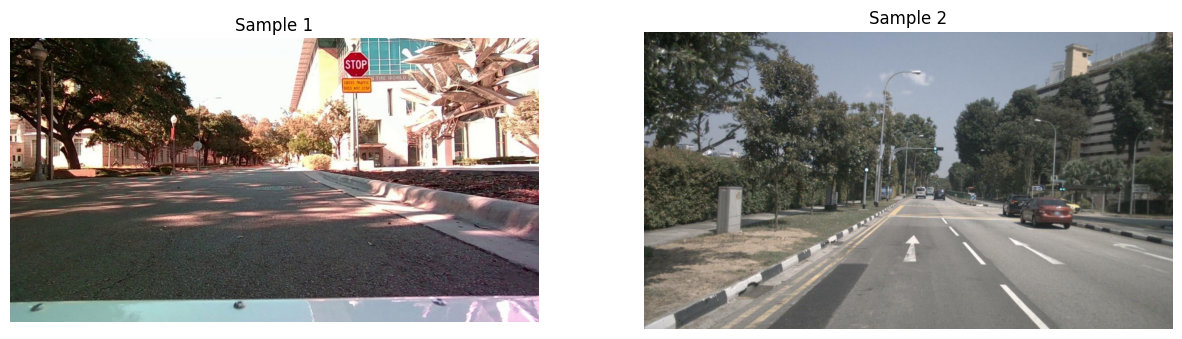

In [10]:
# Now we can view 2 samples and display the difference in the baseline's and our model's responses

image1 = Image.open('./hf_dataset/validation_images/image4.jpg')
image2 = Image.open('./hf_dataset/validation_images/image5.jpg')

# Create a figure and axis for each image
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Display each image on a subplot
axs[0].imshow(image1)
axs[0].axis('off')
axs[0].set_title("Sample 1")

axs[1].imshow(image2)
axs[1].axis('off')
axs[1].set_title("Sample 2")

plt.show()

# Display prompt and each response for the sample images

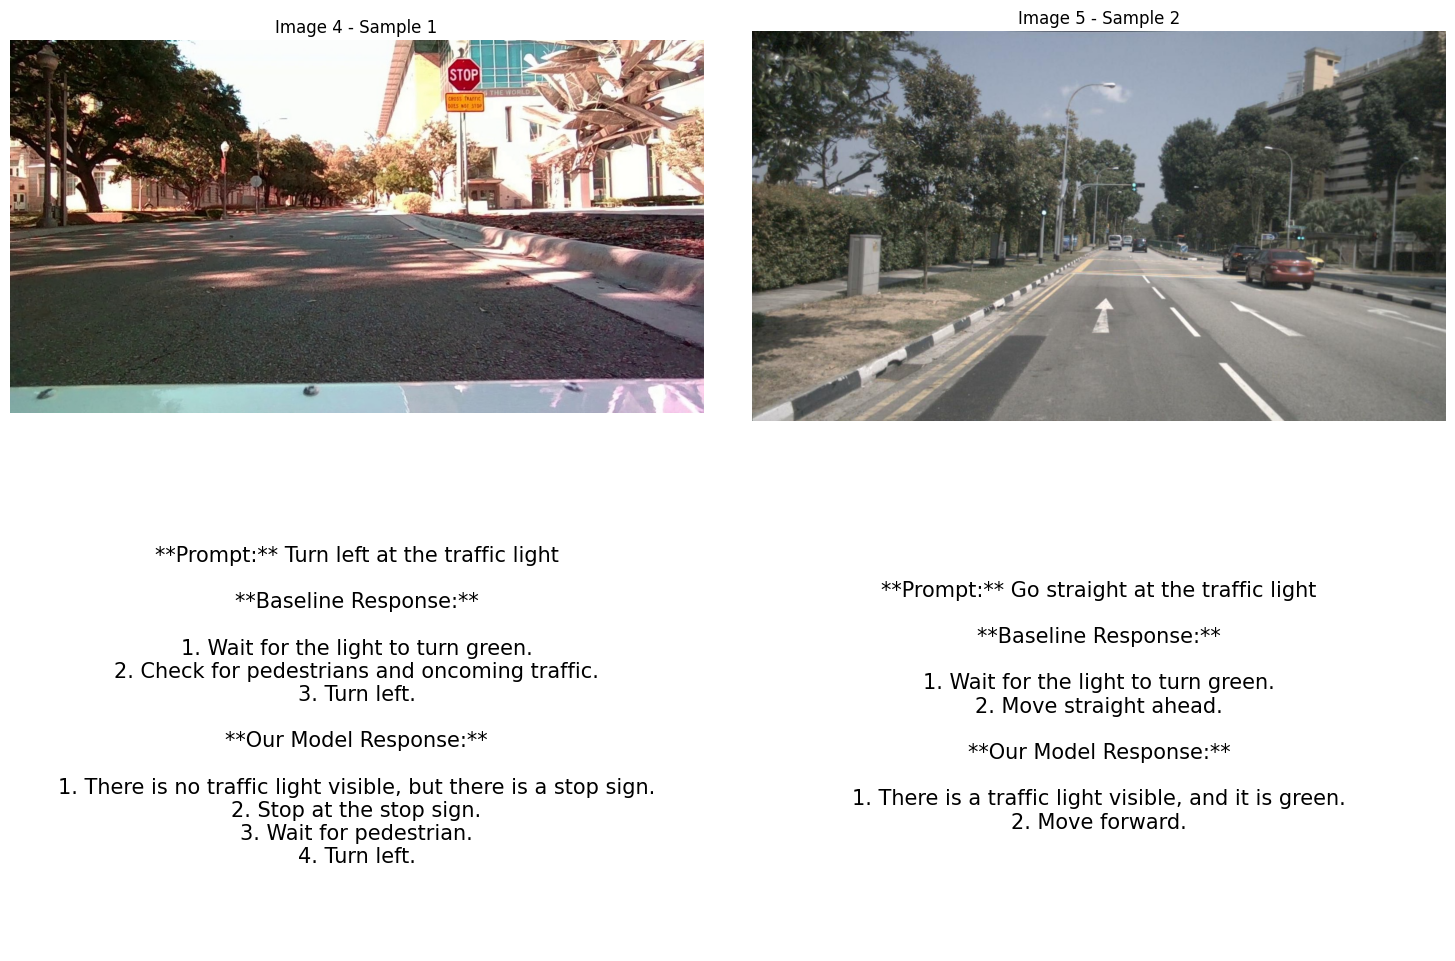

In [12]:
# Load JSON data from both paths
with open('./model_response/baseline/baseline_checkpoint-400.json', 'r') as f:
    baseline_data = json.load(f)

with open('./model_response/our_model/our_model_checkpoint-400.json', 'r') as f:
    our_model_data = json.load(f)

# Define the target images
target_images = [
    "hf_dataset/validation_images/image4.jpg",
    "hf_dataset/validation_images/image5.jpg"
]

# Filter out the relevant samples for each target image
filtered_baseline = [sample for sample in baseline_data if sample['image'] in target_images]
filtered_our_model = [sample for sample in our_model_data if sample['image'] in target_images]

# Load images for display
image1 = Image.open(target_images[0])
image2 = Image.open(target_images[1])

# Create a figure and axis for each image and response
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display each image on the first row of subplots
axs[0, 0].imshow(image1)
axs[0, 0].axis('off')
axs[0, 0].set_title("Image 4 - Sample 1")

axs[0, 1].imshow(image2)
axs[0, 1].axis('off')
axs[0, 1].set_title("Image 5 - Sample 2")

# Display the responses on the second row of subplots
for i, (base_sample, our_sample, ax) in enumerate(zip(filtered_baseline, filtered_our_model, axs[1])):
    prompt = base_sample['conversations'][0]['value']
    baseline_response = base_sample['conversations'][1]['value']
    our_model_response = our_sample['conversations'][1]['value']
    
    # Format and display text response in each subplot
    response_text = (f"**Prompt:** {prompt}\n\n"
                     f"**Baseline Response:**\n{baseline_response}\n\n"
                     f"**Our Model Response:**\n{our_model_response}")
    
    ax.text(0.5, 0.5, response_text, ha='center', va='center', wrap=True, fontsize=15)
    ax.axis('off')

plt.tight_layout()
plt.show()
